# Setting

* 운영체제 : 64비트 운영 체제, x64 기반 프로세서
* 프로세서 : Intel(R) Core(TM) i3-8145U CPU @ 2.10GHz   2.30 GHz
* python : 3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]

# 라이브러리 버전

* numpy==1.23.0
* pandas==1.4.3
* seaborn==0.11.2
* lightgbm==3.3.2

상세한 정보는 requirement.txt 파일안에 있습니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sklearn
import holidays
import math
import lightgbm as lgb
import warnings 

from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [2]:
warnings.filterwarnings(action = 'ignore')

# 데이터 살펴보기

## 데이터 불러오기

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
train.head()

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
0,2018-01-01,NaN,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950
1,2018-01-02,NaN,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136
2,2018-01-03,NaN,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156
3,2018-01-04,NaN,-4.7,-0.7,-8.7,39.0,24.0,43.0,6.2,63.9,1.4,3.5,7102
4,2018-01-05,NaN,-3.0,1.6,-5.6,51.0,35.0,48.4,8.2,84.5,1.7,3.6,7705


In [5]:
test.head()

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max
0,2021-01-01,NaN,-4.2,1.6,-9.8,30.0,17.0,64.0,6.5,67.7,2.0,4.1
1,2021-01-02,NaN,-5.0,-1.4,-8.4,34.0,12.0,38.5,9.0,93.8,2.6,5.4
2,2021-01-03,NaN,-5.6,-2.0,-9.1,39.0,14.0,45.0,5.5,56.7,2.0,4.5
3,2021-01-04,0.0,-3.5,0.3,-8.4,40.0,23.0,51.4,4.6,47.4,1.7,3.2
4,2021-01-05,0.0,-5.5,-2.1,-9.9,30.0,17.0,52.8,8.6,88.7,2.9,5.7


## 데이터 타입 변경

In [6]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

## 결측치 처리

* precipation (강수량) 기상누리에서 결측치=0임을 확인했습니다.
* sunshine_sum (일조량) 일조율=0인 부분만 결측치이므로 결측치=0임을 확인했습니다.
* PH10, PH2.5 (미세먼지) 변수들과 상관관계가 높은 변수들과의 선형회귀모형으로 결측치 대체했습니다.

In [7]:
train.isna().sum()

date               0
precipitation    678
temp_mean          0
temp_highest       0
temp_lowest        0
PM10              67
PM2.5             68
humidity           0
sunshine_sum       5
sunshine_rate      0
wind_mean          0
wind_max           0
rental             0
dtype: int64

In [8]:
test.isna().sum()

date               0
precipitation    205
temp_mean          0
temp_highest       0
temp_lowest        0
PM10               0
PM2.5              0
humidity           0
sunshine_sum       1
sunshine_rate      0
wind_mean          0
wind_max           0
dtype: int64

### 강수량 결측치 처리

In [9]:
train["precipitation"] = train["precipitation"].replace(np.nan, 0)
test["precipitation"] = test["precipitation"].replace(np.nan, 0)

train.head()

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
0,2018-01-01,0.0,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950
1,2018-01-02,0.0,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136
2,2018-01-03,0.0,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156
3,2018-01-04,0.0,-4.7,-0.7,-8.7,39.0,24.0,43.0,6.2,63.9,1.4,3.5,7102
4,2018-01-05,0.0,-3.0,1.6,-5.6,51.0,35.0,48.4,8.2,84.5,1.7,3.6,7705


### 일조량 결측치 처리

In [10]:
#일조율이 0인 부분 = 일조량이 NaN인 부분
train[train['sunshine_sum'].isna()]

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
17,2018-01-18,0.0,2.1,4.5,0.3,80.0,56.0,59.6,NaN,0.0,1.9,3.8,7054
25,2018-01-26,0.0,-14.8,-10.7,-17.8,28.0,18.0,34.9,NaN,0.0,2.6,4.6,3116
45,2018-02-15,0.0,-0.7,4.0,-3.7,32.0,14.0,28.0,NaN,0.0,2.5,4.4,3935
187,2018-07-07,0.0,23.7,29.2,19.5,7.0,5.0,51.4,NaN,0.0,1.6,2.3,48015
604,2019-08-28,0.0,26.1,30.2,23.6,29.0,21.0,66.2,NaN,0.0,1.9,4.3,88718


In [11]:
train["sunshine_sum"] = train["sunshine_sum"].replace(np.nan, 0)
test["sunshine_sum"] = test["sunshine_sum"].replace(np.nan, 0)

train.head()

,date,precipitation,temp_mean,temp_highest,temp_lowest,PM10,PM2.5,humidity,sunshine_sum,sunshine_rate,wind_mean,wind_max,rental
0,2018-01-01,0.0,-1.3,3.8,-5.1,34.0,17.0,39.1,8.3,86.5,1.4,3.8,4950
1,2018-01-02,0.0,-1.8,1.8,-4.3,36.0,22.0,42.0,7.9,82.3,1.8,4.9,7136
2,2018-01-03,0.0,-4.7,-0.4,-7.1,31.0,19.0,42.3,8.6,88.7,2.2,3.5,7156
3,2018-01-04,0.0,-4.7,-0.7,-8.7,39.0,24.0,43.0,6.2,63.9,1.4,3.5,7102
4,2018-01-05,0.0,-3.0,1.6,-5.6,51.0,35.0,48.4,8.2,84.5,1.7,3.6,7705


### PM10, PM2.5 결측치 처리

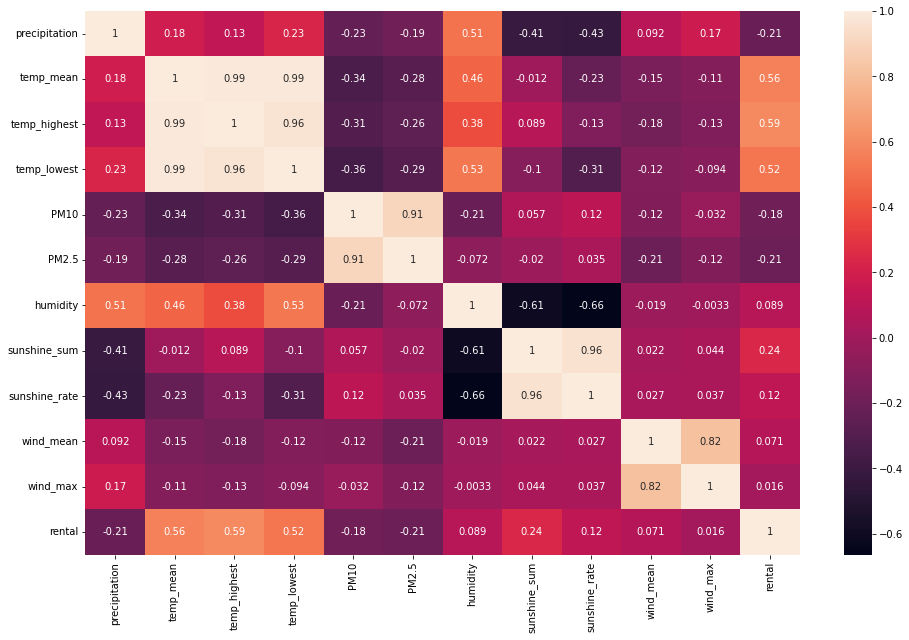

In [12]:
#PM10, PM2.5와 상관관계가 높은 변수들 확인
plt.figure(figsize = (16, 10))
sns.heatmap(train.corr(), annot = True)
plt.show()

In [13]:
## PM10 결측치 처리

# initiate sklearn's linear regression
lin_reg = linear_model.LinearRegression()


# PM10와 상관관계 0.1이상인 변수들만 추출
X = train.dropna(axis=0)[['precipitation', 'temp_mean','PM2.5',
                          'humidity','sunshine_rate','wind_mean']] 
y = train.dropna(axis=0)['PM10'] 

# fitting linear regression model using non-missing values
lin_reg_model = lin_reg.fit(X, y)

# Prediction
y_pred = lin_reg_model.predict(train.dropna(axis=0)[['precipitation', 'temp_mean','PM2.5',
                                                     'humidity','sunshine_rate','wind_mean']])
y_pred

array([32.47343216, 39.41645744, 36.08115325, ..., 68.94657436,
       31.92771616, 25.19123028])

In [14]:
train['PM10'].fillna(pd.Series(y_pred.flatten()), inplace=True)

In [15]:
#PM2.5 결측치 처리

# PM2.5와 상관관계 0.1이상인 변수들만 추출
X2 = train.dropna(axis=0)[['precipitation', 'temp_mean', 'temp_highest','temp_lowest','PM10',
                          'humidity','sunshine_sum','sunshine_rate','wind_mean','wind_max']] 
y2 = train.dropna(axis=0)['PM2.5'] 

# fitting linear regression model using non-missing values
lin_reg_model2 = lin_reg.fit(X2, y2)

# Prediction
y_pred2 = lin_reg_model2.predict(train.dropna(axis=0)[['precipitation', 'temp_mean', 'temp_highest','temp_lowest','PM10'
                                                     ,'humidity','sunshine_sum','sunshine_rate','wind_mean','wind_max']])

train['PM2.5'].fillna(pd.Series(y_pred.flatten()), inplace=True)

train['PM2.5'].isna().sum()

0

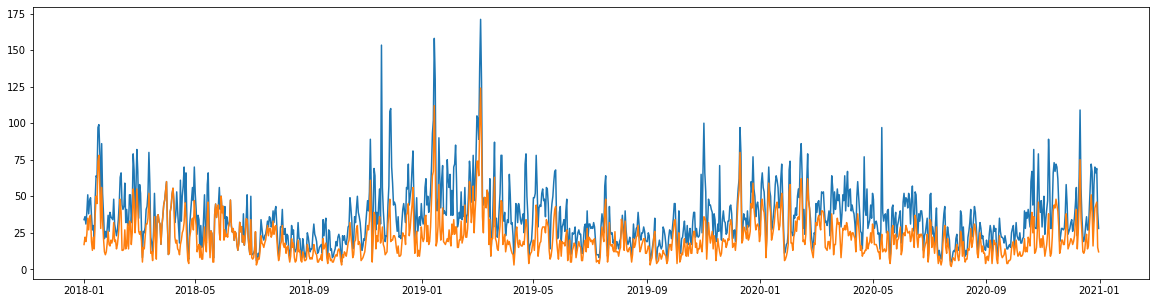

In [16]:
#결측치 채워진 것 확인
plt.figure(figsize = (20,5))
plt.plot(train['date'], train['PM10'])
plt.plot(train['date'], train['PM2.5'])

# 파생변수 생성

### date 변수

date 변수 단독으로 모델에 사용할 수 없기 때문에 년도, 월, 요일로 나누어 변수 생성하였습니다.

In [17]:
# train데이터 년-월-요일 변수 생성

train['date'] = train['date'].astype(str)

def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.date:
        year_point, month_point, day_point = date.split('-')# - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
    return year, month, day

year, month, day = seperate_datetime(train)
    
train['year'] = year
train['month'] = month
train['day'] = day

In [18]:
# test데이터 년-월-요일 변수 생성

test['date'] = test['date'].astype(str)

def seperate_datetime(dataframe):
    year = []
    month = []
    day = []

    for date in dataframe.date:
        year_point, month_point, day_point = date.split('-')# - 기준으로 string을 나누고 list로 만듦 ex) '2016-04-01' -> ['2016', '04', '01']
        year.append(int(year_point))
        month.append(int(month_point))
        day.append(int(day_point))
    return year, month, day

year, month, day = seperate_datetime(test)
    
test['year'] = year
test['month'] = month
test['day'] = day

### 요일 변수

In [19]:
# 요일 변수 선택
week_day = pd.to_datetime(train['date']).dt.weekday
train['week_day'] = week_day

week_day1 = pd.to_datetime(test['date']).dt.weekday
test['week_day'] = week_day1

### 이슬점 변수

In [20]:
#이슬점 변수 생성
def dewtemp(temp, humid):
    b = 17.62
    c = 243.12

    gamma = (b * temp /(c + temp)) + math.log(humid / 100.0)

    dewpoint = (c * gamma) / (b - gamma)
    return dewpoint

train['dew'] = [0] * len(train)
for i in range(len(train)):
    train.dew[i] = dewtemp(train.temp_mean[i], train.humidity[i])
    
test['dew'] = [0] * len(test)
for i in range(len(test)):
    test.dew[i] = dewtemp(test.temp_mean[i], test.humidity[i])

데이터에서의 평균온도(temp_mean)와 습도(humidity)를 이용하여 이슬점 변수를 생성하였습니다. 
이슬점 공식인    
$$Dew point = \frac{243.12*(ln( \frac{Humid}{100 })+\frac{17.62 * T}{243.12 + T})}{17.62-(ln( \frac{Humid}{100 })+\frac{17.62 * T}{243.12 + T})}$$  
을 이용하여 이슬점 변수 생성하였습니다.

# 외부데이터 불러오기

## 가시거리 데이터

In [21]:
# 가시거리 변수만들기
visi1 = pd.read_csv('v1.csv',encoding='cp949')
visi1['일시'] = visi1.일시.str.split(' ').str[0]
visi1['일시'] = pd.to_datetime(visi1['일시'])
groups = visi1.groupby('일시')
v1=pd.concat([groups.mean(), groups.min(), groups.max()], axis=1)
v1.drop(['지점', '지점명'], axis=1,  inplace=True)
v1.columns =["visi_mean", "visi_min", "visi_max"]

visi2 = pd.read_csv('v2.csv',encoding='cp949')
visi2['일시'] = visi2.일시.str.split(' ').str[0]
visi2['일시'] = pd.to_datetime(visi2['일시'])
groups = visi2.groupby('일시')
v2=pd.concat([groups.mean(), groups.min(), groups.max()], axis=1)
v2.drop(['지점', '지점명'], axis=1,  inplace=True)
v2.columns =["visi_mean", "visi_min", "visi_max"]

visi3 = pd.read_csv('v3.csv',encoding='cp949')
visi3['일시'] = visi3.일시.str.split(' ').str[0]
visi3['일시'] = pd.to_datetime(visi3['일시'])
groups = visi3.groupby('일시')
v3=pd.concat([groups.mean(), groups.min(), groups.max()], axis=1)
v3.drop(['지점', '지점명'], axis=1,  inplace=True)
v3.columns =["visi_mean", "visi_min", "visi_max"]

visi4 = pd.read_csv('v4.csv',encoding='cp949')
visi4['일시'] = visi4.일시.str.split(' ').str[0]
visi4['일시'] = pd.to_datetime(visi4['일시'])
groups = visi4.groupby('일시')
v4=pd.concat([groups.mean(), groups.min(), groups.max()], axis=1)
v4.drop(['지점', '지점명'], axis=1,  inplace=True)
v4.columns =["visi_mean", "visi_min", "visi_max"]

v = pd.concat([v1,v2,v3], axis=0)
v.reset_index(inplace=True)
v= v.drop(v[v['일시']=='2019-09-07'].index)
v.reset_index(inplace=True)

v4.reset_index(inplace=True)

자전거 대여량에 가시거리가 영향이 있을 것이라고 생각을 해 외부로부터 가시거리 데이터를 가지고 왔습니다.가시거리 데이터를 이용하여, 일 별 평균 시정, 일 최저 시정, 일 최고 시정을 변수로 생성하였습니다. 

In [22]:
train = pd.concat([train,v], axis=1)
test = pd.concat([test,v4], axis=1)

train.drop(['index', '일시'], axis=1,  inplace=True)
test.drop(['일시'], axis=1,  inplace=True)

## 외부 강수량 데이터

새벽에만 비가 오고 낮에는 화창한 날의 경우, 강수량은 측정되지만 따릉이 대여량은 많게 측정됩니다. 따라서, 온전한 강수량 변수를 사용하는 것이 아닌, 사람들의 활동 시간 (7:00-23:00)에 대한 강수량 파생변수를 생성하였습니다.

또한, 기사에 따르면 따릉이 사용의 대부분이 출퇴근 때 이용되므로 출근시간 (5:00-10:00)에 대한 강수량 변수, 퇴근시간 (16:00-22:00)에 대한 강수량 변수를 파생하였습니다.

In [23]:
pre2018 = pd.read_csv('pre2018.csv',encoding='cp949')
pre2019 = pd.read_csv('pre2019.csv',encoding='cp949')
pre2020 = pd.read_csv('pre2020.csv',encoding='cp949')

In [24]:
pre = pd.concat([pre2018,pre2019,pre2020], axis=0)
pre.reset_index(inplace=True)

In [25]:
train = pd.concat([train,pre], axis=1)
train.drop(['index', 'Unnamed: 0'], axis=1,  inplace=True)

In [26]:
pre2021 = pd.read_csv('pre2021.csv',encoding='cp949')

In [27]:
test= pd.concat([test, pre2021], axis=1)
test.drop(['Unnamed: 0'], axis=1, inplace=True)

기상청자료를 이용하여 변수를 생성하였으며, 데이터 가공의 자세한 내용은 활동강수량 파일을 참고 

# 시각화

## 계절에 따른 변수 상관관계

In [28]:
# 계절나누기
train.loc[(train['month']== 12) | (train['month']== 1)| (train['month']== 2), 'season'] = 'winter'
train.loc[(train['month']== 3) | (train['month']==4)| (train['month']== 5), 'season'] = 'spring'
train.loc[(train['month']== 6) | (train['month']== 7)| (train['month']== 8), 'season'] = 'summer'
train.loc[(train['month']== 9) | (train['month']== 10)| (train['month']== 11), 'season'] = 'fall'

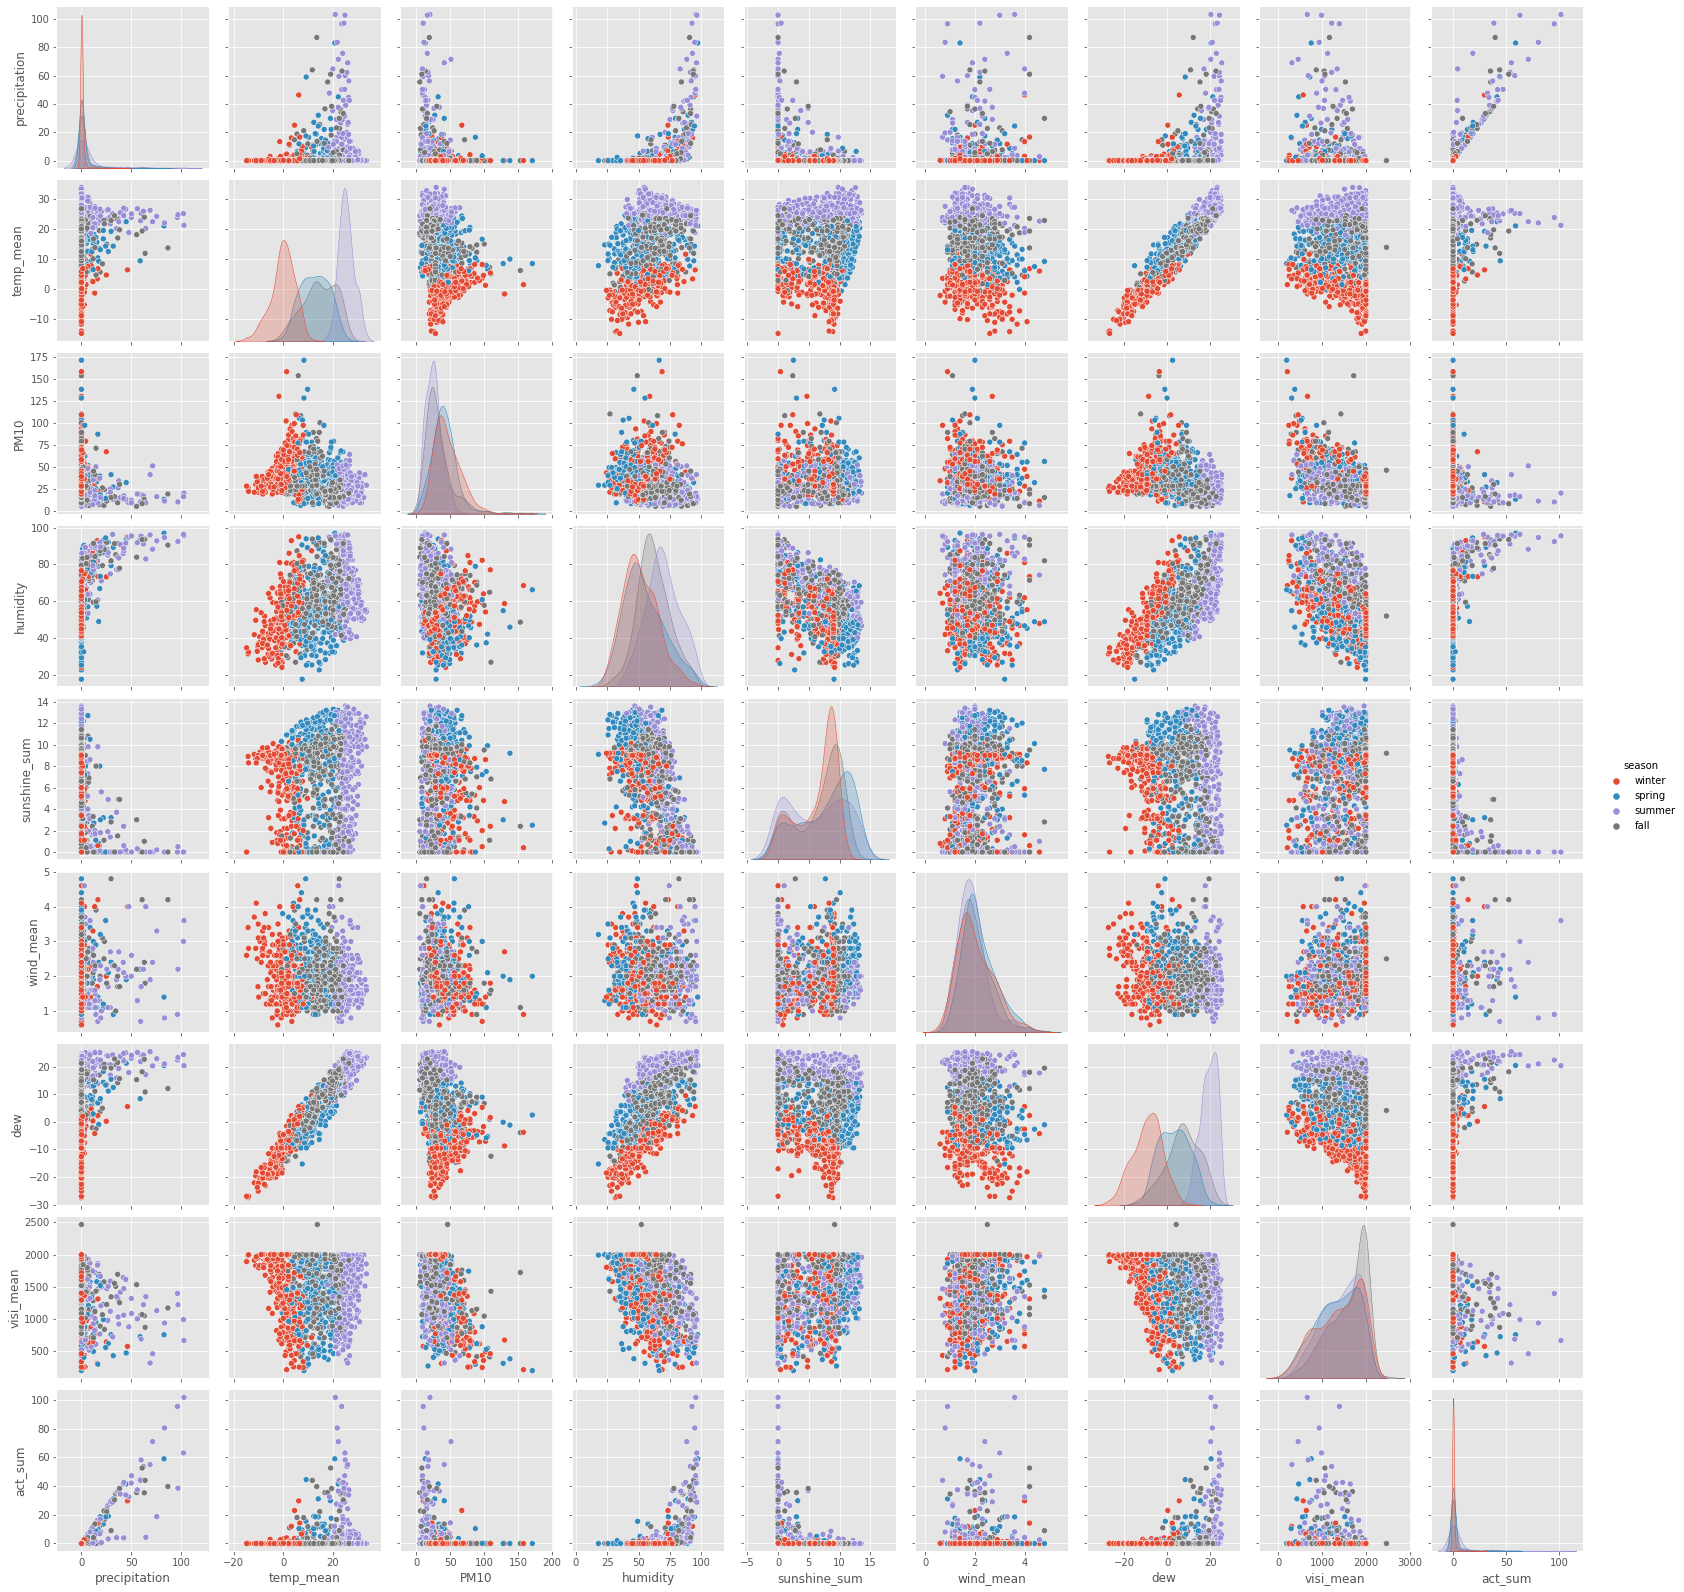

In [29]:
plt.style.use('ggplot')

train_pair = train[['season','precipitation', 'temp_mean', 'PM10', 'humidity', 'sunshine_sum', 'wind_mean','dew', 'visi_mean', 'act_sum']]
sns.pairplot(train_pair, hue='season')

* 계절에 영향을 받는 변수는 temp_mean,  humidity, dew임을 알 수 있습니다.  
* 위의 그래프를 보면 temp_mean,  humidity, dew가 거의 직선과 비슷하며, 이 변수들간의 높은 상관관계를 보임을 알 수 있습니다.  
* 겨울인 경우, 온도가 낮으며 그에 따라 습도가 낮고 이슬점이 낮음을 알 수 있습니다.
* 강수량을 살펴보면 precipitaion은 여름이 높으며, 이에 따라 사람들의 활동이 많은 시간대의 평균 강수량(act_sum)도 높다는 것을 알 수 있습니다.

## 변수간 상관관계

<AxesSubplot:>

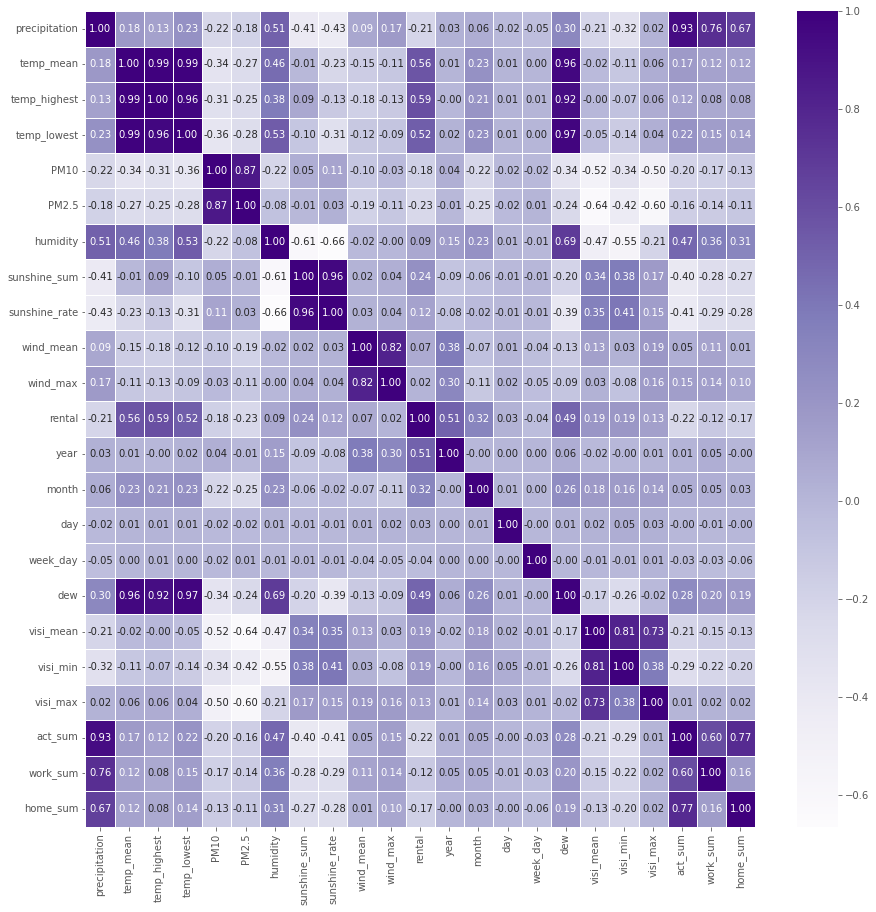

In [30]:
plt.figure(figsize=(15,15))
sns.heatmap(data = train.corr(), annot=True, fmt = '.2f', linewidths=.5, cmap='Purples')

높은 상관관계를 보이는 변수들  
* temp_mean와 temp_high와 temp_lowest  
* sunshine_sum와 sunshine_rate  
* dew와 temp와 관련된 변수    
* precipitation과 act_sum 

위와 같이 상관관계가 높은 변수들은 모델 선택 시, 다중공산성 문제가 생기지 않도록 변수들을 선택하는 것이 중요합니다. 

## 년도, 월, 일, 요일별 따릉이 대여량

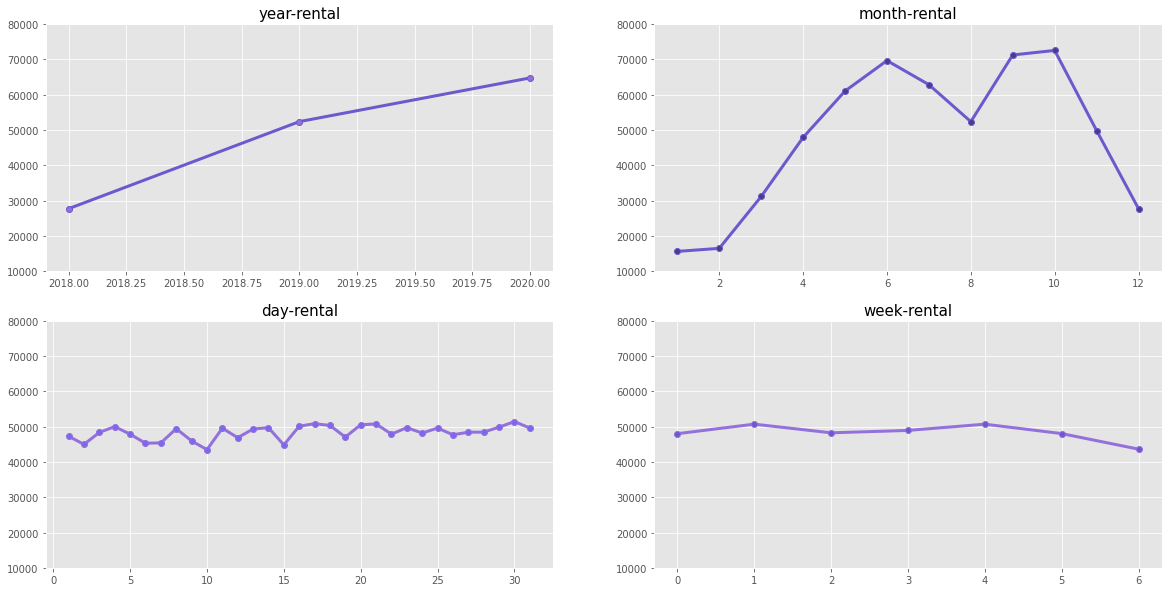

In [31]:
# 년별 평균 자전거 대여 수 구하기
df_year = pd.pivot_table(train, index=train['year'], values=["rental"], aggfunc=['mean'])

# 월별 평균 자전거 대여 수 구하기
df_month = pd.pivot_table(train, index=train['month'], values=["rental"], aggfunc=['mean'])

# 일별 평균 자전거 대여 수 구하기
df_day = pd.pivot_table(train, index=train['day'], values=["rental"], aggfunc=['mean'])

# 요일별 평균 자전거 대여 수 구하기
df_week = pd.pivot_table(train, index=train['week_day'], values=["rental"], aggfunc=['mean'])

plt.style.use('ggplot')

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

ax1.set_ylim([10000,80000])
ax2.set_ylim([10000,80000])
ax3.set_ylim([10000,80000])
ax4.set_ylim([10000,80000])

ax1.plot(df_year, marker='o', markerfacecolor='mediumpurple', color='slateblue', linewidth=3)
ax2.plot(df_month, marker='o', markerfacecolor='darkslateblue', color='slateblue', linewidth=3)
ax3.plot(df_day, marker='o', markerfacecolor='mediumslateblue', color='mediumpurple', linewidth=3)
ax4.plot(df_week, marker='o', markerfacecolor='slateblue', color='mediumpurple', linewidth=3)

ax1.set_title('year-rental', size=15)
ax2.set_title('month-rental', size=15)
ax3.set_title('day-rental', size=15)
ax4.set_title('week-rental', size=15)

plt.show()

* year과 rental의 관계를 보고, 년이 올라갈수록 rental의 수가 증가하는 추세임을 알 수 있습니다.
* month와 rental의 관계를 보고, 여름 8월과 겨울 12월 1월 2월에 rental의 수가 줄어듦을 알 수 있습니다.  
* day와 rental의 관계를 보고, day와 rental의 관계를 크게 상관없음을 알 수 있습니다.
* week와 rental의 관계를 보고, 토요일과 일요일에 rental의 수가 약간 줄어들었음을 알 수 있습니다.  

## 따릉이 대여량과 다른 변수들간의 관계

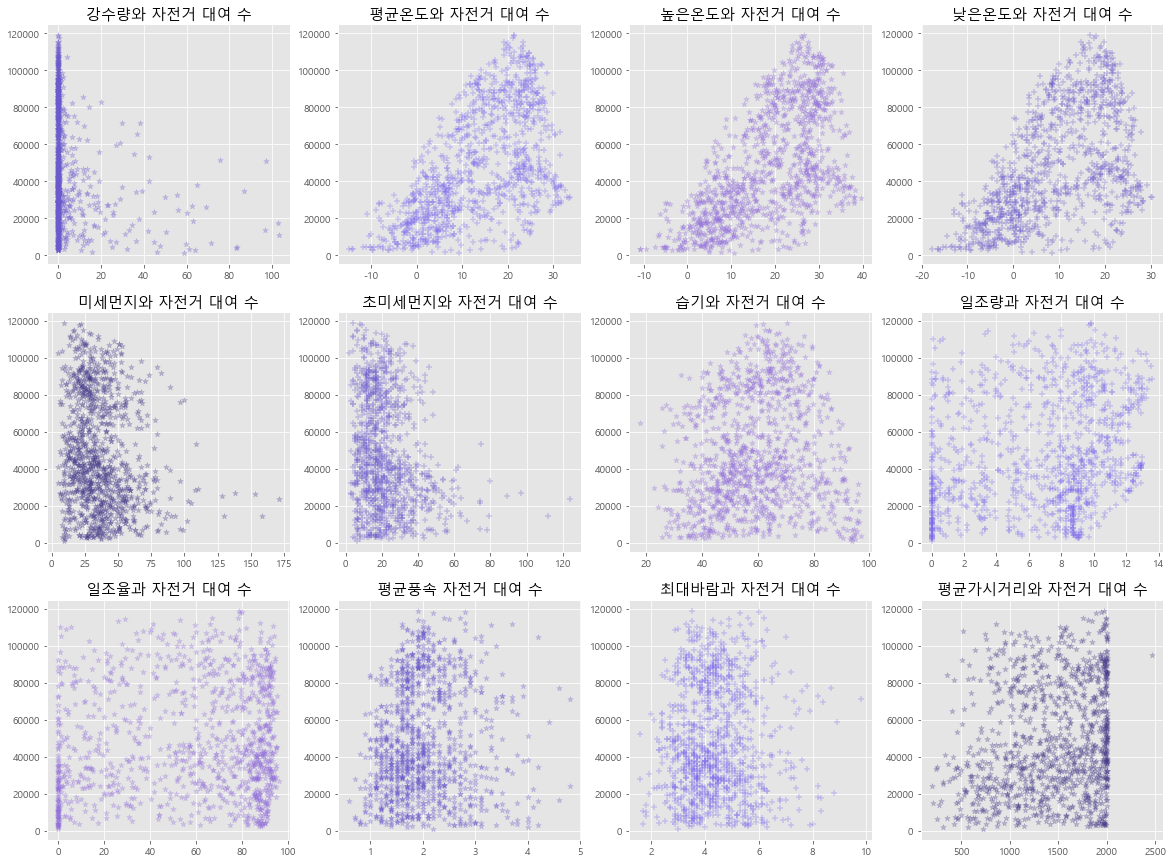

In [32]:
# 글꼴 설정 & 음수 부호설정
plt.rcParams.update({'font.family':'Malgun Gothic','font.size':12}) 
plt.rc('axes',unicode_minus=False) 


plt.style.use('ggplot')

fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(3, 4, 1)
ax2 = fig.add_subplot(3, 4, 2)
ax3 = fig.add_subplot(3, 4, 3)
ax4 = fig.add_subplot(3, 4, 4)
ax5 = fig.add_subplot(3, 4, 5)
ax6 = fig.add_subplot(3, 4, 6)
ax7 = fig.add_subplot(3, 4, 7)
ax8 = fig.add_subplot(3, 4, 8)
ax9 = fig.add_subplot(3, 4, 9)
ax10 = fig.add_subplot(3, 4, 10)
ax11 = fig.add_subplot(3, 4, 11)
ax12 = fig.add_subplot(3, 4, 12)

ax1.scatter(train['precipitation'], train['rental'], marker='*', color='slateblue', alpha=0.3)
ax2.scatter(train['temp_mean'], train['rental'], marker='+', color='mediumslateblue', alpha=0.3)
ax3.scatter(train['temp_highest'], train['rental'], marker='*', color='mediumpurple', alpha=0.3)
ax4.scatter(train['temp_lowest'], train['rental'], marker='+', color='slateblue', alpha=0.3)
ax5.scatter(train['PM10'], train['rental'], marker='*', color='darkslateblue', alpha=0.3)
ax6.scatter(train['PM2.5'], train['rental'], marker='+', color='slateblue', alpha=0.3)
ax7.scatter(train['humidity'], train['rental'], marker='*', color='mediumpurple', alpha=0.3)
ax8.scatter(train['sunshine_sum'], train['rental'], marker='+', color='mediumslateblue', alpha=0.3)
ax9.scatter(train['sunshine_rate'], train['rental'], marker='*', color='mediumpurple', alpha=0.3)
ax10.scatter(train['wind_mean'], train['rental'], marker='*', color='slateblue', alpha=0.3)
ax11.scatter(train['wind_max'], train['rental'], marker='+', color='mediumslateblue', alpha=0.3)
ax12.scatter(train['visi_mean'], train['rental'], marker='*', color='darkslateblue', alpha=0.3)

ax1.set_title('강수량와 자전거 대여 수', size=15)
ax2.set_title('평균온도와 자전거 대여 수', size=15)
ax3.set_title('높은온도와 자전거 대여 수', size=15)
ax4.set_title('낮은온도와 자전거 대여 수', size=15)
ax5.set_title('미세먼지와 자전거 대여 수', size=15)
ax6.set_title('초미세먼지와 자전거 대여 수', size=15)
ax7.set_title('습기와 자전거 대여 수', size=15)
ax8.set_title('일조량과 자전거 대여 수', size=15)
ax9.set_title('일조율과 자전거 대여 수', size=15)
ax10.set_title('평균풍속 자전거 대여 수', size=15)
ax11.set_title('최대바람과 자전거 대여 수', size=15)
ax12.set_title('평균가시거리와 자전거 대여 수', size=15)

plt.show()

* 강수량이 적게 올수록 자전거 대여량이 많습니다.
* 온도가 너무 높거나 낮으면 자전거 대여량이 적습니다.  
* 미세먼지가 적을수록 자전거 대여량이 적습니다.
* 습기가 너무 높거나 낮은 것보다 적당할 때 자전거 대여량이 많습니다  
* 가시거리가 높을수록 자전거 대여량이 많습니다.

# 변수 선택

## 총 13개의 변수 선택

* 강수량 : 강수량을 사람들의 활동시간, 출근시간, 퇴근시간으로 각각 나누어 변수 선택하였습니다.
* 온도 : 온도에 따른 따릉이 대여량은 관계가 높다고 판단하였습니다.
* 일조량 : 햇빛이 많이 쬐는 날과 아닌 날은 따릉이 대여량과의 관계가 높다고 판단하였습니다.
* 가시거리(최대, 최소) : 사람들의 눈으로 볼 수 있는 가장 먼 거리로 따릉이 대여량과 관계가 높다고 판단하였습니다
* 이슬점 : 공기가 포화되어 수증기가 응결할 때의 온도, 계산식에 습기와 온도가 사용되어 따릉이 대여량과의 높은 관계가 있다고 판단하였습니다.
* 초미세먼지 : 대기질 지수는 따릉이 대여량에 관계가 높다고 판단하였습니다.
* 년도 : 년도에 따라 대여량 상승하여 높은 상관관계가 있다고 판단하였습니다.
* 월 : 월별로 계절에 따라 대여량의 변화가 의미가 있다고 판단하였습니다.

In [33]:
X = train.loc[:, [ 'act_sum', 'work_sum', 'home_sum',  'temp_mean',  'sunshine_sum', 'visi_mean', 'visi_max', 'visi_min', 'PM2.5',  'week_day',  'year', 'month', 'dew']]
y = train['rental']

test1 =test.loc[:, [ 'act_sum', 'work_sum', 'home_sum',  'temp_mean',  'sunshine_sum', 'visi_mean', 'visi_max', 'visi_min', 'PM2.5', 'week_day', 'year', 'month', 'dew']]

# 모델 선택 및 파라미터 설정

랜덤포레스트, 다항회귀 등 다양한 모델을 수행해 제출을 시도했으나, 0.3xxx 대 혹은 0.2xxx 후반대의 점수를 기록해 좀 더 예측 성능을 높일 수 있는 모델을 사용해야겠다고 생각했습니다. 

그래서, 최근 데이터 경진 대회에서 가장 각광받는 알고리즘인 부스팅 기법 중 XGBoost와 LightGBM 알고리즘을 사용해보았고, get_nmae를 이용해 nmae 지표를 확인해본 결과, 어떠한 파라미터도 설정하지 않았을 때, XGBoost보다 LightGBM 알고리즘이 더 높은 성능을 보이는 것을 확인해 모델로 LightGBM 알고리즘을 선택하게 되었습니다.

## 사전 준비

In [34]:
# 평가지표 함수
def get_nmae(pred, y):
    nmae = np.mean(abs(pred-y)/y)
    return nmae

In [35]:
#train데이터를 학습, 검증데이터 분리 후 모델 학습
X_train, X_test, y_train, y_test=train_test_split(X,
                                                  y,
                                                  random_state=0)

print("X_train 크기:", X_train.shape)
print("y_train 크기:", y_train.shape)
print("X_test 크기:", X_test.shape)
print("y_test 크기:", y_test.shape)

X_train 크기: (821, 13)
y_train 크기: (821,)
X_test 크기: (274, 13)
y_test 크기: (274,)


## 하이퍼파라미터 튜닝(GridSearchCV 이용)

그리드서치에서 scoring으로 nmae를 사용하기 위해 앞서 정의한 get_nmae함수 이용해서 nmae_score 정의

In [36]:
nmae_score = make_scorer(get_nmae, greater_is_better=False)   

In [37]:
lg = lgb.LGBMRegressor()
param_grid = {
    'max_depth' : [8,19,29],
    'min_data_in_leaf' : [19,24,28]
}

gs = GridSearchCV(lg, param_grid = param_grid, scoring = nmae_score, cv = 3)
gs.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=24, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=24
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28
[LightGBM] [Warning] min

GridSearchCV(cv=3, estimator=LGBMRegressor(),
             param_grid={'max_depth': [8, 19, 29],
                         'min_data_in_leaf': [19, 24, 28]},
             scoring=make_scorer(get_nmae, greater_is_better=False))

In [38]:
gs.best_params_

{'max_depth': 19, 'min_data_in_leaf': 19}

LightGBM의 기본적인 파라미터들인 max_depth와 min_data_in_leaf 만을 이용해 GridSearchCV를 진행하였고, 이를 통해 max_depth는 19, min_data_in_leaf = 19에서 가장 좋은 성능을 가진다는 것을 확인할 수 있었습니다.

# 최종모델

최종모델은 앞서, GridSearchCV를 이용해 1차적으로 튜닝한 파라미터들에, learning_rate와 n_estimators를 추가하여 모델을 생성하였습니다. 


일반적으로 n_estimators를 크게 하고, learning_rate를 작게 하면 예측성능을 향상시킬 수 있다고하여 임의로, n_estimators는 700, learning_rate는 0.04로 설정하였습니다.

In [39]:
model_lgb = lgb.LGBMRegressor(learning_rate=0.04, n_estimators=700,max_depth=19,min_data_in_leaf=19)

In [40]:
model_lgb.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.04, max_depth=19, min_data_in_leaf=19,
              n_estimators=700)

In [41]:
X_pred = model_lgb.predict(X_train)
get_nmae(X_pred, y_train)

0.01803892528914526

In [42]:
pred = model_lgb.predict(X_test)
get_nmae(pred, y_test)

0.1349989969813512

In [43]:
model_lgb.fit(X,y)
lgb_pred = model_lgb.predict(test1)

[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19


# 결과도출

In [44]:
reg_2018 = sum(train.loc[train['year'] == 2018, 'rental'].values)
reg_2019 = sum(train.loc[train['year'] == 2019, 'rental'].values)
reg_2020 = sum(train.loc[train['year'] == 2020, 'rental'].values)

a_89 = reg_2019/reg_2018
a_90 = reg_2020/reg_2019

print(a_89)
print(a_90)

1.8836727252111978
1.2429259327402773


2018년에서 2019년으로갈때, 따릉이 이용량은 1.88배, 2019년에서 2020년은 1.24배 증가했다. LightGBM은 이 상승분 추세를 학습시켜줄 수 없으므로 연도에 따른 따릉이 대여량의 상승률분을 고려해주었다. 따라서, 소수점을 바꿔가며 가장 성능이 좋은 1.31배를 적용시켜 주었다.

In [45]:
lgb_pred = 1.31*lgb_pred

In [46]:
# 정답파일 생성
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission["rental"] =lgb_pred
sample_submission.to_csv('last.csv', index = False)

# 출처 링크

* 기상청 기상자료 개발 포털

https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36

* 따릉이 출퇴근시간 대여량 급증 기사 

http://naver.me/FVcRfk1T